# Compare the GMST and ocean/atmosphere dynamic sea level anomalies for different scenarios

We investigate here the possibility that GMST is not a good driver for this part of sea level.

This is based on an NCL script: CompTE_GMST.ncl

In [247]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.formula.api as sm

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [112]:
DIR_PROJ = '/Users/dewilebars/Projects/Project_ProbSLR/'
DIR_ZOS  = DIR_PROJ+'Project_ProbSLR_archiveKNMIwks/CMIP5_ThermalExp/'
DIR_T    = DIR_PROJ+'Data_Proj/Data_AR5/Tglobal/'

SCE      = 'rcp26' #('rcp26', 'rcp45', 'rcp85')

per1 = (1986, 2005)
per2 = (2091, 2099)

In [173]:
def read_ModelNames(ds):
    '''Read model names, this need a little function because characters are not
    read properly by xarray'''
    mod_names = []
    for i in range(len(ds.ModelNames)):
        mod_names.append(str(ds.ModelNames[i].values)[2:-1])
    return mod_names

def sl_anom(DIR_ZOS, SCE, per1, per2):
    '''Compute global and regional sea level anomalies and the GMST associated'''
    print('### Working on scenario '+str(SCE))
    fzos     = xr.open_dataset(DIR_ZOS+'CMIP5_SeaLevel_'+SCE+'_zos_1986-2100.nc')
    fzostoga = xr.open_dataset(DIR_ZOS+'CMIP5_SeaLevel_'+SCE+'_zostoga_1986-2100.nc')
    fzossga  = xr.open_dataset(DIR_ZOS+'CMIP5_SeaLevel_'+SCE+'_zossga_1986-2100.nc')
    fzos_avg = xr.open_dataset(DIR_ZOS+'CMIP5_SeaLevel_'+SCE+'_zos_avg_1986-2100.nc')

    time     = fzos.time
    dimt     = len(time)
    zos      = np.array(fzos.LocalSeaLevel)
    zostoga  = np.array(fzostoga.GlobalSeaLevel)
    zossga   = np.array(fzossga.GlobalSeaLevel)
    zos_avg  = np.array(fzos_avg.AverageSeaLevel) 
    dimzos = zos.shape
    print('Number of models with zos available: '+str(dimzos[0]))

    zos_ModelNames     = read_ModelNames(fzos)
    zostoga_ModelNames = read_ModelNames(fzostoga)
    zossga_ModelNames  = read_ModelNames(fzossga)
    zos_avg_ModelNames = read_ModelNames(fzos_avg)

    ### Combine global and regional sea level change
    glob_sl = np.zeros(zos.shape)
    for m in range(0,dimzos[0]):
        try:
            inds = zostoga_ModelNames.index(zos_ModelNames[m])
            glob_sl[m,:]  = zostoga[inds,:]
            #print('Using '+zos_ModelNames[m]+' with zostoga for global')
        except:
            try:
                inds = zossga_ModelNames.index(zos_ModelNames[m])
                glob_sl[m,:]  = zossga[inds,:]
                print("Using "+zos_ModelNames[m]+' with zossga for global')
            except:
                print("No global steric data for "+zos_ModelNames[m])
                glob_sl[m,:] = np.nan
        if zos_ModelNames[m] not in ['NorESM1-M', 'NorESM1-ME', 'GISS-E2-R', 
                                     'GISS-E2-R-CC', 'CNRM-CM5']:
            # These are the models for which the Boussinesq approximation is not
            # made so the global mean is zostoga, therefore it should not be 
            # removed. CNRM-CM5 is Boussinesq but seems to have included 
            # zostoga in zosga.
            try:
                inds = zos_avg_ModelNames.index(zos_ModelNames[m])
                glob_sl[m,:] = glob_sl[m,:] - zos_avg[inds,:]
            except:
                print('Missing zos_avg for model '+zos_ModelNames[m])

    tot_sl  = zos + glob_sl

    ind_s1 = np.where(time==per1[0]+.5)[0][0]
    ind_e1 = np.where(time==per1[1]+.5)[0][0]
    ind_s2 = np.where(time==per2[0]+.5)[0][0] # 2081.5
    ind_e2 = np.where(time==per2[1]+.5)[0][0]

    tot_sl_avg1  = tot_sl[:,ind_s1:ind_e1+1].mean(axis=1)
    tot_sl_avg2  = tot_sl[:,ind_s2:ind_e2+1].mean(axis=1)
    glob_sl_avg1 = glob_sl[:,ind_s1:ind_e1+1].mean(axis=1)
    glob_sl_avg2 = glob_sl[:,ind_s2:ind_e2+1].mean(axis=1)

    Delta_tot_sl  = tot_sl_avg2 - tot_sl_avg1
    Delta_glob_sl = glob_sl_avg2 - glob_sl_avg1
    
    # Temperature anomalies computation
    temp  = np.zeros(dimzos)
    temp_avg1 = np.zeros(dimzos[0])
    temp_avg2 = np.zeros(dimzos[0])
    col_names = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                 'Sep', 'Oct', 'Nov', 'Dec']
    for m in range(dimzos[0]):
        #print('Reading temperature for '+zos_ModelNames[m])
        file_name = 'global_tas_Amon_'+zos_ModelNames[m]+'_'+SCE+'_r1i1p1.dat'
        try:
            TEMP = pd.read_csv(DIR_T+file_name, comment='#', delim_whitespace=True, \
                               names=col_names)
            timeT = TEMP['Year'][:]
            TEMPy = TEMP.iloc[:,1:].mean(axis=1) # Compute yearly averages
            ind_s1 = np.where(timeT==1986)[0][0]
            ind_e1 = np.where(timeT==2005)[0][0]
            ind_s2 = np.where(timeT==2091)[0][0]
            ind_e2 = np.where(timeT==2099)[0][0]
            temp_avg1[m] = TEMPy[ind_s1:ind_e1+1].mean()
            temp_avg2[m] = TEMPy[ind_s2:ind_e2+1].mean()
            del(TEMP)
            del(timeT)
            del(TEMPy)
        except:
            print('Temperature file missing for: '+zos_ModelNames[m])
            temp_avg1[m] = np.nan
            temp_avg2[m] = np.nan
    Delta_temp    = temp_avg2 - temp_avg1
    
    return zos_ModelNames, Delta_glob_sl, Delta_tot_sl, Delta_temp

In [174]:
res_df = pd.DataFrame()
for SCE in ('rcp26', 'rcp45', 'rcp85'):
    ModNames, Delta_glob_sl, Delta_tot_sl, Delta_temp = sl_anom(DIR_ZOS, SCE, per1, per2)
    df = pd.DataFrame({'Model': ModNames,
                       'GMST_'+str(SCE):Delta_temp, 
                       'GMSL_'+str(SCE):Delta_glob_sl, 
                       'RegSL_'+str(SCE):Delta_tot_sl})
    df = df.set_index('Model')
    res_df = pd.concat([res_df,df], axis=1, sort=False)
res_df

### Working on scenario rcp26
Number of models with zos available: 21
Using GFDL-ESM2G with zossga for global
Using GFDL-ESM2M with zossga for global
No global steric data for FGOALS-g2
Temperature file missing for: FGOALS-g2
### Working on scenario rcp45
Number of models with zos available: 28
No global steric data for IPSL-CM5B-LR
Using GFDL-ESM2G with zossga for global
Using GFDL-ESM2M with zossga for global
No global steric data for FGOALS-g2
No global steric data for EC-EARTH
Temperature file missing for: GISS-E2-R-CC
### Working on scenario rcp85
Number of models with zos available: 30
No global steric data for IPSL-CM5B-LR
Using GFDL-ESM2G with zossga for global
Using GFDL-ESM2M with zossga for global
No global steric data for FGOALS-g2
No global steric data for EC-EARTH
Using CNRM-CM5 with zossga for global
Temperature file missing for: bcc-csm1-1-m
Temperature file missing for: GISS-E2-R-CC
Temperature file missing for: EC-EARTH
Temperature file missing for: CMCC-CESM


,GMST_rcp26,GMSL_rcp26,RegSL_rcp26,GMST_rcp45,GMSL_rcp45,RegSL_rcp45,GMST_rcp85,GMSL_rcp85,RegSL_rcp85
bcc-csm1-1,0.904869,0.109060,0.196486,1.493322,0.153571,0.219145,3.601621,0.255516,0.400573
bcc-csm1-1-m,0.773876,0.088448,0.116924,1.491412,0.133388,0.169849,NaN,0.233687,0.294379
MIROC-ESM,1.731490,0.057019,0.412054,2.494688,0.089042,0.506351,4.933048,0.224536,0.687610
MIROC5,1.002037,0.193997,0.276532,1.690502,0.215833,0.376342,3.507628,0.317257,0.557418
MIROC-ESM-CHEM,1.709440,0.123686,0.397195,2.565684,0.138102,0.524973,5.305760,0.237761,0.743693
IPSL-CM5A-LR,1.219171,0.213054,0.251312,2.225582,0.285144,0.316512,4.775574,0.425944,0.487695
IPSL-CM5A-MR,1.120937,0.193954,0.234795,2.286868,0.265370,0.307210,4.675090,0.418007,0.480205
GFDL-ESM2G,0.232540,0.115770,0.114848,0.962558,0.150239,0.157022,2.983218,0.230675,0.419729
GFDL-ESM2M,0.664543,0.141454,0.121261,1.159453,0.188278,0.189203,2.884828,0.279422,0.353111
NorESM1-M,0.822171,0.147962,0.261539,1.694063,0.195560,0.372436,3.415947,0.300127,0.576368


In [170]:
res_df.corr()

,GMST_rcp26,GMSL_rcp26,RegSL_rcp26,GMST_rcp45,GMSL_rcp45,RegSL_rcp45,GMST_rcp85,GMSL_rcp85,RegSL_rcp85
GMST_rcp26,1.000000,-0.048336,0.539061,0.944435,-0.208120,0.534045,0.899949,0.098466,0.329274
GMSL_rcp26,-0.048336,1.000000,0.026725,0.003578,0.952280,0.072530,-0.016295,0.875771,-0.006730
RegSL_rcp26,0.539061,0.026725,1.000000,0.578157,-0.056946,0.967707,0.411373,0.041162,0.917951
GMST_rcp45,0.944435,0.003578,0.578157,1.000000,-0.132117,0.423674,0.958889,0.064342,0.364958
GMSL_rcp45,-0.208120,0.952280,-0.056946,-0.132117,1.000000,0.046230,-0.172227,0.940676,0.037876
RegSL_rcp45,0.534045,0.072530,0.967707,0.423674,0.046230,1.000000,0.296977,0.073534,0.946263
GMST_rcp85,0.899949,-0.016295,0.411373,0.958889,-0.172227,0.296977,1.000000,0.041261,0.156149
GMSL_rcp85,0.098466,0.875771,0.041162,0.064342,0.940676,0.073534,0.041261,1.000000,0.039278
RegSL_rcp85,0.329274,-0.006730,0.917951,0.364958,0.037876,0.946263,0.156149,0.039278,1.000000


In [241]:
# Regression coefficients
SCE = ['rcp26', 'rcp45', 'rcp85']
all_df = pd.DataFrame()
for sce in SCE:
    all_df = all_df.append(res_df[['GMST_'+sce,'GMSL_'+sce, 'RegSL_'+sce]].rename(
        columns={'GMST_'+sce: 'GMST', 'GMSL_'+sce: 'GMSL', 'RegSL_'+sce: 'RegSL'}), sort=False)

all_reg_GMSL_GMST = sm.ols(formula='GMSL ~ GMST', data=all_df).fit()
all_reg_RegSL_GMST = sm.ols(formula='RegSL ~ GMST', data=all_df).fit()
all_reg_GMSL_GMST.params

Intercept    0.103521
GMST         0.040889
dtype: float64

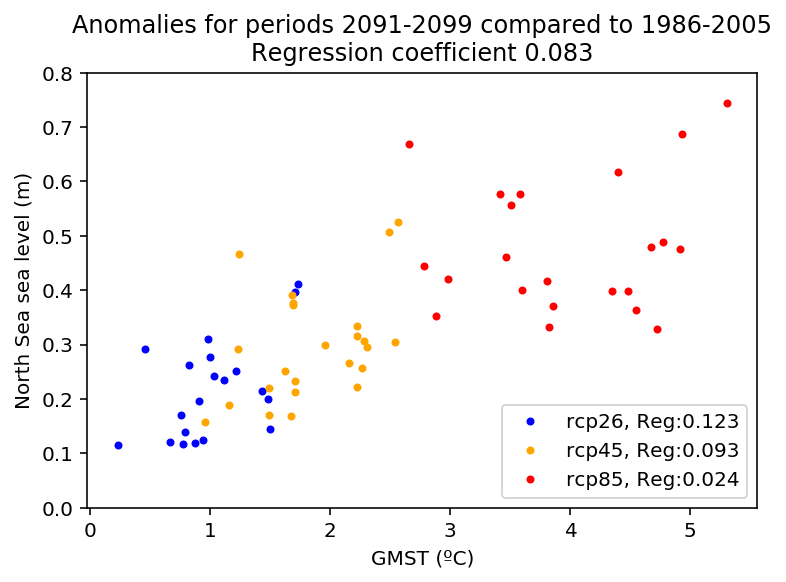

In [251]:
# Plot
fig, ax = plt.subplots()
colors = ['blue', 'orange', 'red']
for i in range(3):
    reg = sm.ols(formula='RegSL_'+SCE[i]+' ~ GMST_'+SCE[i], data=res_df).fit()
    ax.plot(res_df['GMST_'+SCE[i]], res_df['RegSL_'+SCE[i]], '.', 
            color=colors[i], label=SCE[i]+', Reg:'+str(round(reg.params[1],3)))

plt.legend(loc='lower right')
ax.set_title('Anomalies for periods '+str(per2[0])+'-'+str(per2[1])+
             ' compared to '+str(per1[0])+'-'+str(per1[1]) +'\n'+
             'Regression coefficient '+str(round(all_reg_RegSL_GMST.params[1],3)))
ax.set_xlabel('GMST (ºC)')
ax.set_ylabel('North Sea sea level (m)')
ax.set_ylim([0,0.8]);

#plt.savefig('../figures/SLvsGMST_NorthSea.pdf', dpi=150)

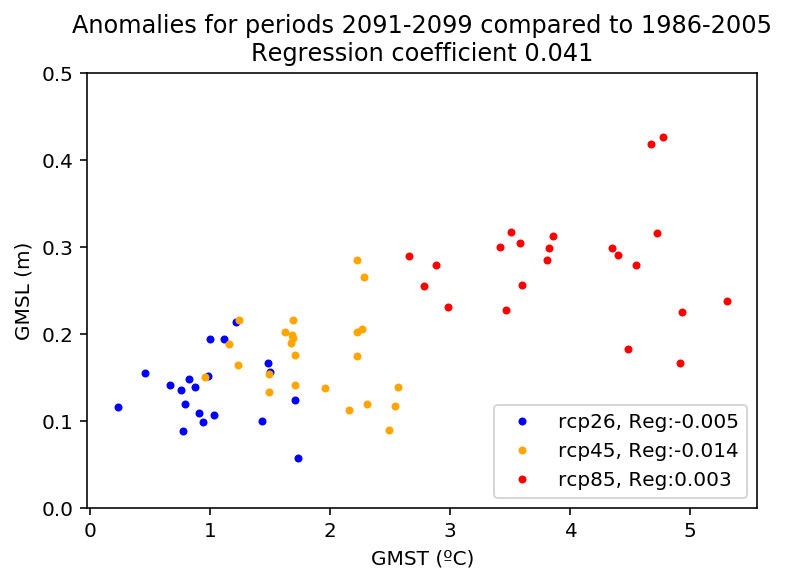

In [253]:
# Plot
fig, ax = plt.subplots()
colors = ['blue', 'orange', 'red']
for i in range(3):
    reg = sm.ols(formula='GMSL_'+SCE[i]+' ~ GMST_'+SCE[i], data=res_df).fit()
    ax.plot(res_df['GMST_'+SCE[i]], res_df['GMSL_'+SCE[i]], '.', 
            color=colors[i], label=SCE[i]+', Reg:'+str(round(reg.params[1],3)))

plt.legend(loc='lower right')
ax.set_title('Anomalies for periods '+str(per2[0])+'-'+str(per2[1])+
             ' compared to '+str(per1[0])+'-'+str(per1[1]) +'\n'+
             'Regression coefficient '+str(round(all_reg_GMSL_GMST.params[1],3)))
ax.set_xlabel('GMST (ºC)')
ax.set_ylabel('GMSL (m)')
ax.set_ylim([0,0.5]);

#plt.savefig('../figures/SLvsGMST_Global.pdf', dpi=150)